## 1. Data

출처 : https://www.kaggle.com/puneet6060/intel-image-classification

Colab-Kaggle 연동 :
https://medium.com/hyunjulie/%EC%BA%90%EA%B8%80%EA%B3%BC-%EA%B5%AC%EA%B8%80-colab-%EC%97%B0%EA%B2%B0%ED%95%B4%EC%A3%BC%EA%B8%B0-6a274f6de81d

In [9]:
!pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ssdsdssdf","key":"11aafa15185daed492bd71d9e24fc41e"}'}

In [10]:
ls -1ha kaggle.json

kaggle.json


In [13]:
!chmod 600 /root/.kaggle/kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [18]:
!kaggle datasets download -d puneet6060/intel-image-classification

 95% 329M/346M [00:02<00:00, 153MB/s]
100% 346M/346M [00:02<00:00, 152MB/s]


In [19]:
!ls

 intel-image-classification.zip  'kaggle (2).json'   sample_data
'kaggle (2) (1).json'		  kaggle.json


In [ ]:
!unzip intel-image-classification.zip

## 2. DataLoader

In [21]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'
pred_path = '/content/seg_pred/seg_pred'

In [24]:
# 전처리 class
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

In [25]:
# dataset & dataloader
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=6, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=6, pin_memory=True)

classes = os.listdir(train_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
classes

['mountain', 'glacier', 'buildings', 'forest', 'street', 'sea']

## 3. Model


![image](https://user-images.githubusercontent.com/44194558/153146152-2928d39f-fe8b-4853-98f1-1294f99a6efc.png)

In [36]:
import torch.nn as nn
from torchsummary import summary
import numpy as np
import math
import pdb

In [48]:
# 첫 번째 layer에서 사용되는 conv 함수 (conv2d)
def conv_bn(input_dim, output_dim, stride):
    return  nn.Sequential(
                nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(output_dim),
                nn.ReLU6(inplace=True)
    )

# inverted bottleneck layer 바로 다음에 사용되는 conv 함수 (conv2d 1x1)
def conv_1x1_bn(input_dim, output_dim):
    return  nn.Sequential(
                nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(output_dim),
                nn.ReLU6(inplace=True)
        )
    
# channel수를 무조건 8로 나누어 떨어지게 만드는 함수
def make_divisible(x, divisible_by=8):
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)

### 3.1 Inverted Residual Block

![image](https://user-images.githubusercontent.com/44194558/153146351-d788b81f-bd0e-4e9d-8734-50de131a515c.png)

<br/>

![image](https://user-images.githubusercontent.com/44194558/153146619-4f4fe888-e81e-416c-b84c-8705fc763162.png)

1st block : stride=1, no expansion 

 - [32, 112, 112] -> [16, 112, 112]

In [57]:
class InvertedResidual(nn.Module):
    def __init__(self, input_dim, output_dim, stride, expand_ratio):
        super(InvertedResidual, self).__init__()

        self.stride = stride
        assert stride in [1, 2]  # stride=1일 때만 skip-conn 가능

        hidden_dim = input_dim * expand_ratio  # intermediate expansion

        self.use_res_connect = self.stride==1 and input_dim==output_dim  # skip-conn이 가능한 지 확인

        if expand_ratio == 1:  # 첫 번째 bottleneck block에서만
            self.conv = nn.Sequential(
                # depthwise-conv3x3 (groups 옵션 사용)
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),  # non-linearity

                # pointwise-conv1x1 (linear)
                nn.Conv2d(hidden_dim, output_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(output_dim)
            )

        else:
            self.conv = nn.Sequential(
                # expansion-conv1x1
                nn.Conv2d(input_dim, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),  # non-linearity

                # depthwise-conv3x3
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),  # non-linearity

                # pointwise-conv1x1 (linear)
                nn.Conv2d(hidden_dim, output_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(output_dim)
            )
            
    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)  # skip conn

        else:
            return self.conv(x)

### 3.1 MobileNetV2

![image](https://user-images.githubusercontent.com/44194558/153146152-2928d39f-fe8b-4853-98f1-1294f99a6efc.png)


In [61]:
class MobileNetV2(nn.Module):

    def __init__(self, n_class=1000, input_size=224, width_mult=1.):  # n_class는 태스크에 맞게 수정
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        
        # [t, c, n, s] - [expand_ratio, output_channel, # of iterations, stride]
        interverted_residual_setting = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]
        
        # 1st layer (conv2d)
        assert input_size % 32 == 0
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]  # (N, 224, 224, 3) -> (N, 112, 112, 32) 

        # Inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, t))  # 반복되는 부분에서 skip-conn 적용

                input_channel = output_channel
        
        # Last layer (conv2d 1x1)
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))  # (N, 320, 7, 7) -> (N, 1280, 7, 7)

        self.features = nn.Sequential(*self.features)

        self.avg = nn.AvgPool2d(7, 7)
        self.classifier = nn.Linear(self.last_channel, n_class)

        self._initialize_weights()

    def forward(self, x):
        # pdb.set_trace()
        x = self.features(x)
        x = self.avg(x)
        x = x.view(-1, self.last_channel)
        x = self.classifier(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [62]:
def mobilenet_v2(pretrained=True):
    model = MobileNetV2(width_mult=1)

    if pretrained:
        try:
            from torch.hub import load_state_dict_from_url
        except ImportError:
            from torch.utils.model_zoo import load_url as load_state_dict_from_url

        # 사전 학습된 가중치 불러오기    
        state_dict = load_state_dict_from_url(
            'https://www.dropbox.com/s/47tyzpofuuyyv1b/mobilenetv2_1.0-f2a8633.pth.tar?dl=1', progress=True)
        
        # 사전 학습된 가중치를 모델에 로드
        model.load_state_dict(state_dict)

    return model

## 4. Train

In [63]:
# 모델 구축
model = mobilenet_v2(True)
model.classifier = nn.Linear(model.classifier.in_features, len(classes)).to(device)  # classifier의 출력 변경
model = model.to(device)

In [68]:
model

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

In [ ]:
summary(model, (3, 224, 224), device=device)

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
best_acc = 0
epochs = 10

In [71]:
def train(epoch):
    model.train()

    train_loss = 0
    correct = 0
    total = 0

    for index, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)  # pred
        loss = criterion(outputs, targets)  # loss
        
        # 역전파
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        if (index+1) % 20 == 0:
            print(f'[Train] | epoch: {epoch+1}/{epochs} | batch: {index+1}/{len(train_loader)}| loss: {loss.item():.4f} | Acc: {correct / total * 100:.4f}')


def test(epoch):
    global best_acc
    model.eval() 
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # 역전파 x
        for index, (inputs, targets) in enumerate(test_loader):

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # pred
            loss = criterion(outputs, targets)  # loss
         
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
        print(f'[Test] epoch: {epoch+1} loss: {test_loss:.4f} | Acc: {correct / total * 100:.4f}')    

    # Save checkpoint.   
    acc = 100.*correct / total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'): 
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc       

In [74]:
for epoch in range(epochs):
    train(epoch)
    test(epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Train] | epoch: 1/10 | batch: 20/110| loss: 0.3760 | Acc: 90.8203
[Train] | epoch: 1/10 | batch: 40/110| loss: 0.3527 | Acc: 90.6250
[Train] | epoch: 1/10 | batch: 60/110| loss: 0.2450 | Acc: 90.9635
[Train] | epoch: 1/10 | batch: 80/110| loss: 0.2655 | Acc: 90.7715
[Train] | epoch: 1/10 | batch: 100/110| loss: 0.3001 | Acc: 90.7734
[Test] epoch: 1 loss: 6.4565 | Acc: 91.5667
Saving..
[Train] | epoch: 2/10 | batch: 20/110| loss: 0.2810 | Acc: 92.0312
[Train] | epoch: 2/10 | batch: 40/110| loss: 0.2806 | Acc: 92.1680
[Train] | epoch: 2/10 | batch: 60/110| loss: 0.1782 | Acc: 92.2266
[Train] | epoch: 2/10 | batch: 80/110| loss: 0.2996 | Acc: 92.2266
[Train] | epoch: 2/10 | batch: 100/110| loss: 0.2572 | Acc: 92.2578
[Test] epoch: 2 loss: 5.6850 | Acc: 91.9000
Saving..
[Train] | epoch: 3/10 | batch: 20/110| loss: 0.3573 | Acc: 92.8125
[Train] | epoch: 3/10 | batch: 40/110| loss: 0.2498 | Acc: 93.0273
[Train] | epoch: 3/10 | batch: 60/110| loss: 0.1214 | Acc: 93.2292
[Train] | epoch: 3/10

## 5. Inference

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<Figure size 432x288 with 0 Axes>

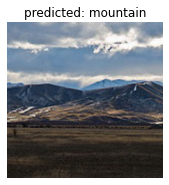

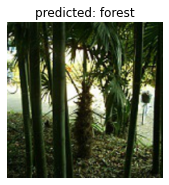

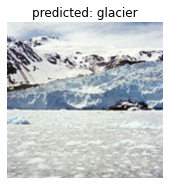

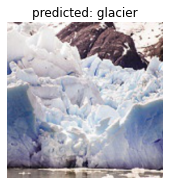

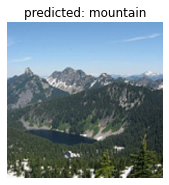

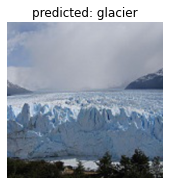

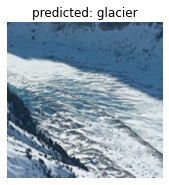

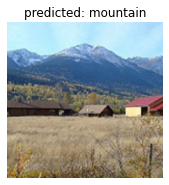

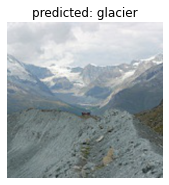

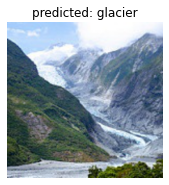

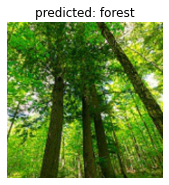

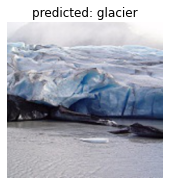

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import time
import torchvision


class Archive(Dataset):
    def __init__(self, path, transform=None):
        img_name = [f for f in os.listdir(path)]
        self.imgList = [os.path.join(path, i) for i in img_name]
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.imgList)

    def __getitem__(self, idx):
        image = Image.open(self.imgList[idx]).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)
        return image


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, inputs in enumerate(pred_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
 
            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.figure(figsize=(20,20))
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

if __name__ == '__main__':

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_path = '/content/seg_train/seg_train'
    pred_path = '/content/seg_pred/seg_pred'
    classes = sorted(os.listdir(train_path))

    pred_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])

    pred_dataset = Archive(pred_path, transform=pred_transform)
    pred_loader = DataLoader(pred_dataset, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)

    model = mobilenet_v2(False)
    model.classifier = nn.Linear(model.classifier.in_features, len(classes)).to(device)  # 1000 -> 6

    checkpoint = torch.load('checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['model'])

    model = model.to(device)
    visualize_model(model)